# TOF Sensor Basic Tests

## Objective

The objective of this notebook is to analyze the effectiveness of WaveShare's Time of Flight (TOF) sensor at measuring distance at stationary points of fixed intervals, under various conditions. From here, we will be able to get a rough idea of the sensor's overall distance measuring capabilities.

## Overview

- For each test, I placed the sensor at fixed intervals of 0.5m, from 0.5m to 5.0m facing a wall, and allowed it to generate roughly 500 points of distance measurements.
- I conducted this test indoors, outdoors, and outdoors with a 3D-printed case acting as a shade.
- For the indoors and outdoors tests, I used the software provided by WaveShare to extract the data from the sensor into an Excel file. For the last test, I used a Raspberry Pi and some Python code to extract the data into a text file.
- In this notebook, I proceed to take the data collected, plot in various graphs and draw relevant conclusions.

### Data Collected with Software vs Raspberry Pi

- For all tests, the measurements collected at each distance interval (e.g. 0.5m, 1.0m, etc.) is stored in a separate file, in their respective [folders](./data/basic_tests/).
- One difference of the data collected using the Raspberry Pi is that each point of measurement is associated with a 'signal strength' value, and if the signal strength is 0, the distance recorded is labeled as -1. Usually, when the signal strength is 0, the distance measured is unreliable and inaccurate.
- Therefore, after extracting the data from the Raspberry Pi, I preprocess it by extracting only the distances, removing the -1 values, and convert values from millimeters to meters.

### WaveShare Documentation

- WaveShare's [documentation](https://www.waveshare.com/wiki/TOF_Laser_Range_Sensor#Specification) states that the accuracy of the TOF sensor would be affected by natural light. Therefore, I expect that the outdoor measurements will end up being more inaccurate and unprecise than the indoor measurements.
- Furthermore, it gave an estimate of the accuracy and standard deviation depending on the distances measured:

||Short Range (0 to 2.16m)|Mid Range (2.16 to 3.60 m)|Long Range (> 3.60m)|
|---|---|---|---|
|Accuracy|±1.0cm|±1.0cm|±1.5cm|
|Standard Deviation|0.3cm|1.5cm|8cm|

### Code

- To prevent this notebook from being cluttered, I have split some of the code into separate Python modules found in the same directory.
- [`data_loader`](./data_loader.py) contains helper functions to extract the data from the necessary files.
- [`graphing`](./graphing.py) contains helper functions to plot the graphs below.
- [`preprocessing`](./preprocessing.py) contains utility functions that manipulate the data.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

from data_loader import get_tof_data_from_txt, get_tof_data_from_xlsx, get_data_from_folder
from graphing import BasicGraphs
from preprocessing import DataCleaner, get_mean_measurements, get_standard_deviations

In [2]:
graphs = BasicGraphs()
data_cleaner = DataCleaner()

## Data Analysis

- First, I gauge the accuracy of the sensor at each test by taking the average of the distances measured at each interval and plotting a line graph against the actual distance intervals.
- Next, I gauge precision by plotting the cluster of raw data points at each interval.
- To get a better visual of precision, I plot the standard deviation of the distances measured at each distance interval.
- Finally, I attempt to evaluate the effectiveness of a simple cleaning algorithm by drawing a best fit curve for each test.

### Setup

- In the code below, I first create a graphs object to help plot the various graphs I want.
- Then, I extract the raw data from the respective indoors, outdoors, and with shade tests.

In [3]:
ACTUAL_DISTANCES = [0.5 * i for i in range(1, 11)]
OUTDOORS_DATA_PATH = pathlib.Path("./data/tof_basic_tests/outdoors")
INDOORS_DATA_PATH = pathlib.Path("./data/tof_basic_tests/indoors")
WITH_SHADE_DATA_PATH = pathlib.Path("./data/tof_basic_tests/with_shade/")

outdoors_raw_data = get_data_from_folder(OUTDOORS_DATA_PATH, get_tof_data_from_xlsx)
indoors_raw_data = get_data_from_folder(INDOORS_DATA_PATH, get_tof_data_from_xlsx)

with_shade_raw_data = get_data_from_folder(WITH_SHADE_DATA_PATH, get_tof_data_from_txt)
with_shade_raw_data = [distance_interval[1] for distance_interval in with_shade_raw_data]
with_shade_raw_data = [[round(distance / 1000, 2) for distance in distance_interval if distance != -1] for distance_interval in with_shade_raw_data]

### Accuracy

- We evaluate the sensor's accuracy by plotting the mean measured distance at each interval against the actual distance being measured.
- First, I create a table comparing the average measurement at each distance interval compared to the actual distances.

In [4]:
outdoors_mean = get_mean_measurements(outdoors_raw_data)
indoors_mean = get_mean_measurements(indoors_raw_data)
with_shade_mean = get_mean_measurements(with_shade_raw_data)

data = {
    "Actual Distance": ACTUAL_DISTANCES,
    "Outdoors Mean": outdoors_mean,
    "Indoors Mean": indoors_mean,
    "With Shade Mean": with_shade_mean
}
df = pd.DataFrame(data)
display(df.T)

,0,1,2,3,4,5,6,7,8,9
Actual Distance,0.50,1.0,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00
Outdoors Mean,0.50,1.0,1.54,2.11,2.60,2.96,3.28,3.33,3.32,2.96
Indoors Mean,0.52,1.0,1.50,2.02,2.50,3.02,3.52,4.04,4.35,4.06
With Shade Mean,0.50,1.0,1.50,1.96,2.38,2.83,3.06,2.49,2.75,1.70


- Next I plot the graphs, where we can see that the sensor performs far better under indoor conditions where it is not exposed to natural light.
- In the outdoors graph, the sensor gives accurate results until around 3.0m where it seems unable to measure any further. However, in the indoors graph, the sensor measures the actual distance almost perfectly up until 4.0m.
- It is also interesting to see in both graphs that the average measured distances dip at 5.0m. It is possible that this is because of the huge amount of spurious data produced by the sensor as it gets more inaccurate, leading to a lower average.
- Interestingly, we also see that the sensor performs far worse with the shade in outdoors conditions. I suspect that this is because at further distances, like 3.0 meters onwards, the shade actually impedes with the sensor's ability to collect data. I realized that a slight tilt in the angle of the sensor will see the shade interferring with the measurement of the sensor.

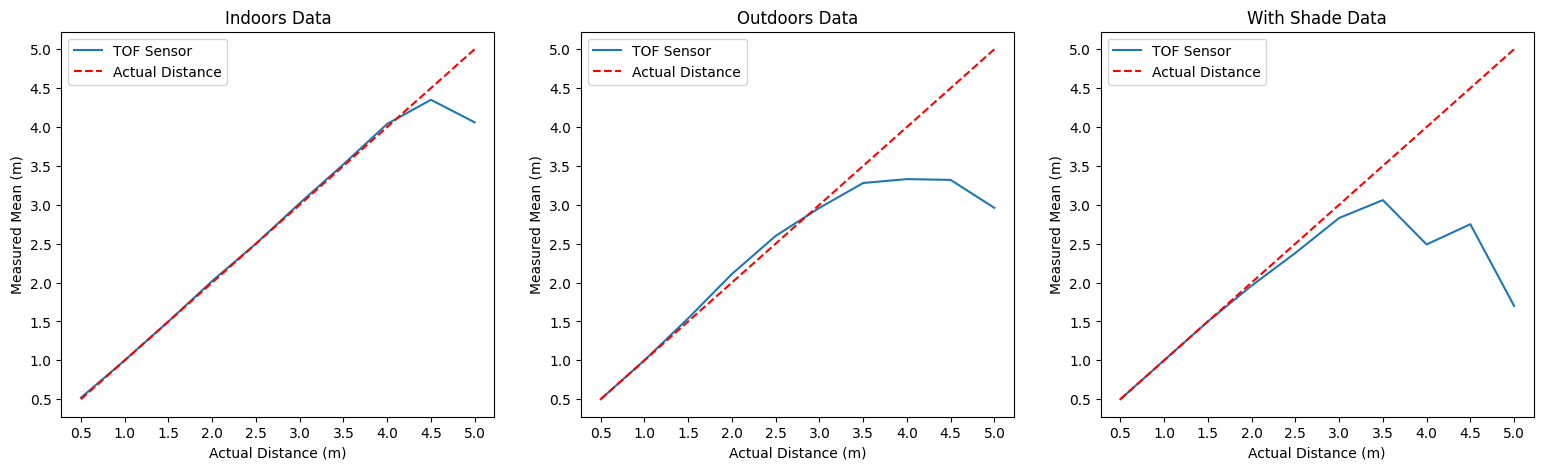

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(19, 5))
graphs.plot_mean_vs_actual_distance(axes[0], indoors_mean, title="Indoors Data")
graphs.plot_mean_vs_actual_distance(axes[1], outdoors_mean, title="Outdoors Data")
graphs.plot_mean_vs_actual_distance(axes[2], with_shade_mean, title="With Shade Data")
plt.show()

### Precision

- Next, we can evaluate the precision of the sensor by plotting a scatter plot of the raw data to see how closely measured points are to each other.
- We can see from the outdoors graph that the sensor is highly unreliable in bright daylight. From 1.5m onwards, the sensor outputs an increasingly large amount of spurious data. On the other hand, the indoors graph reveals that the sensor remains very precise indoors, and up until 3.5m, the amount of spurious data produced remains minimal.
- We also see the benefit of using the shade in an outdoors condition. Although the amount of spurious data from 3.0m onwards is still a lot, before that, the sensor performs with more precision compared to the outdoors data. This implies that using a shade might increase the reliability of the sensor at close distances.

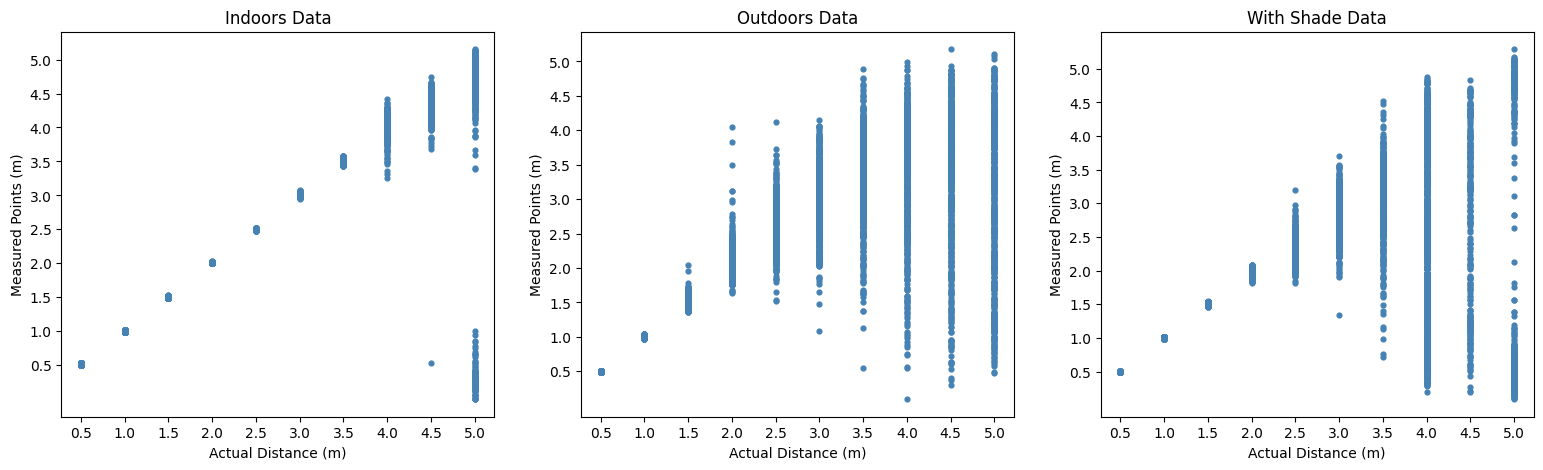

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(19, 5))
graphs.plot_scatter(axes[0], indoors_raw_data, title="Indoors Data")
graphs.plot_scatter(axes[1], outdoors_raw_data, title="Outdoors Data")
graphs.plot_scatter(axes[2], with_shade_raw_data, title="With Shade Data")

### Standard Deviation

- We can also plot the standard deviation of the points measured at each interval.
- Again, we can see that in under strong daylight, the sensor's precision is compromised by it's high standard deviation after interval 2.0m. In contrast, in an indoors environment, the standard deviation remains extremely low up until 4.5m onwards. This again shows how the sensor's reliability is strongly tied to the amount of natural light it is exposed to.
- At the same time, the with shade data again shows that the shade allows the sensor to be more precise at close intervals. Compared to the outdoors data, the standard deviation at each point is smaller up until 3.5m.

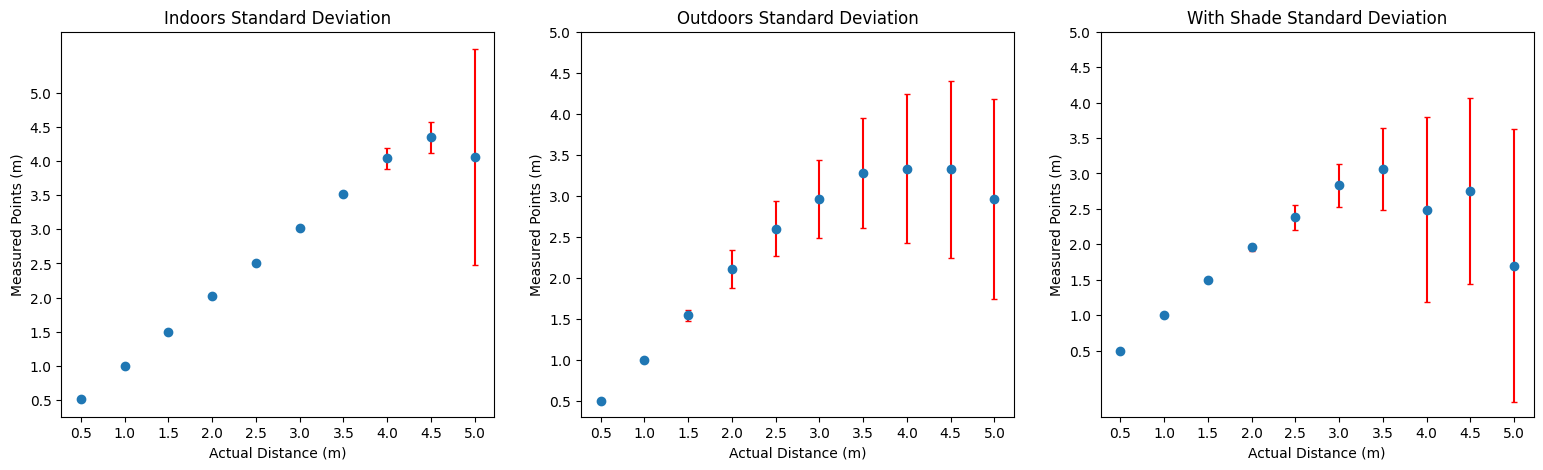

In [7]:
outdoors_std = get_standard_deviations(outdoors_raw_data)
indoors_std = get_standard_deviations(indoors_raw_data)
with_shade_std = get_standard_deviations(with_shade_raw_data)

fig, axes = plt.subplots(1, 3, figsize=(19, 5))
graphs.plot_std_errorbar(axes[0], indoors_mean, indoors_std, title="Indoors Standard Deviation")
graphs.plot_std_errorbar(axes[1], outdoors_mean, outdoors_std, title="Outdoors Standard Deviation")
graphs.plot_std_errorbar(axes[2], with_shade_mean, with_shade_std, title="With Shade Standard Deviation")

plt.show()

### Best Fit Line

#### Cleaning the Data

- Another way of showing the reliability of the sensor is by drawing a best fit curve through the average measurements at each interval. The closer the line is to a linear, $y = x$ curve, the more accurate it is.
- However, we the amount of spurious data that we have, our best fit curve will not be very accurate.
- Therefore, we can attempt to clean the preprocess the data before fitting it with a curve. One possibility is to remove all points greater than 1 standard deviation from the mean.
- Below we compare the graphs of the cleaned and raw data.

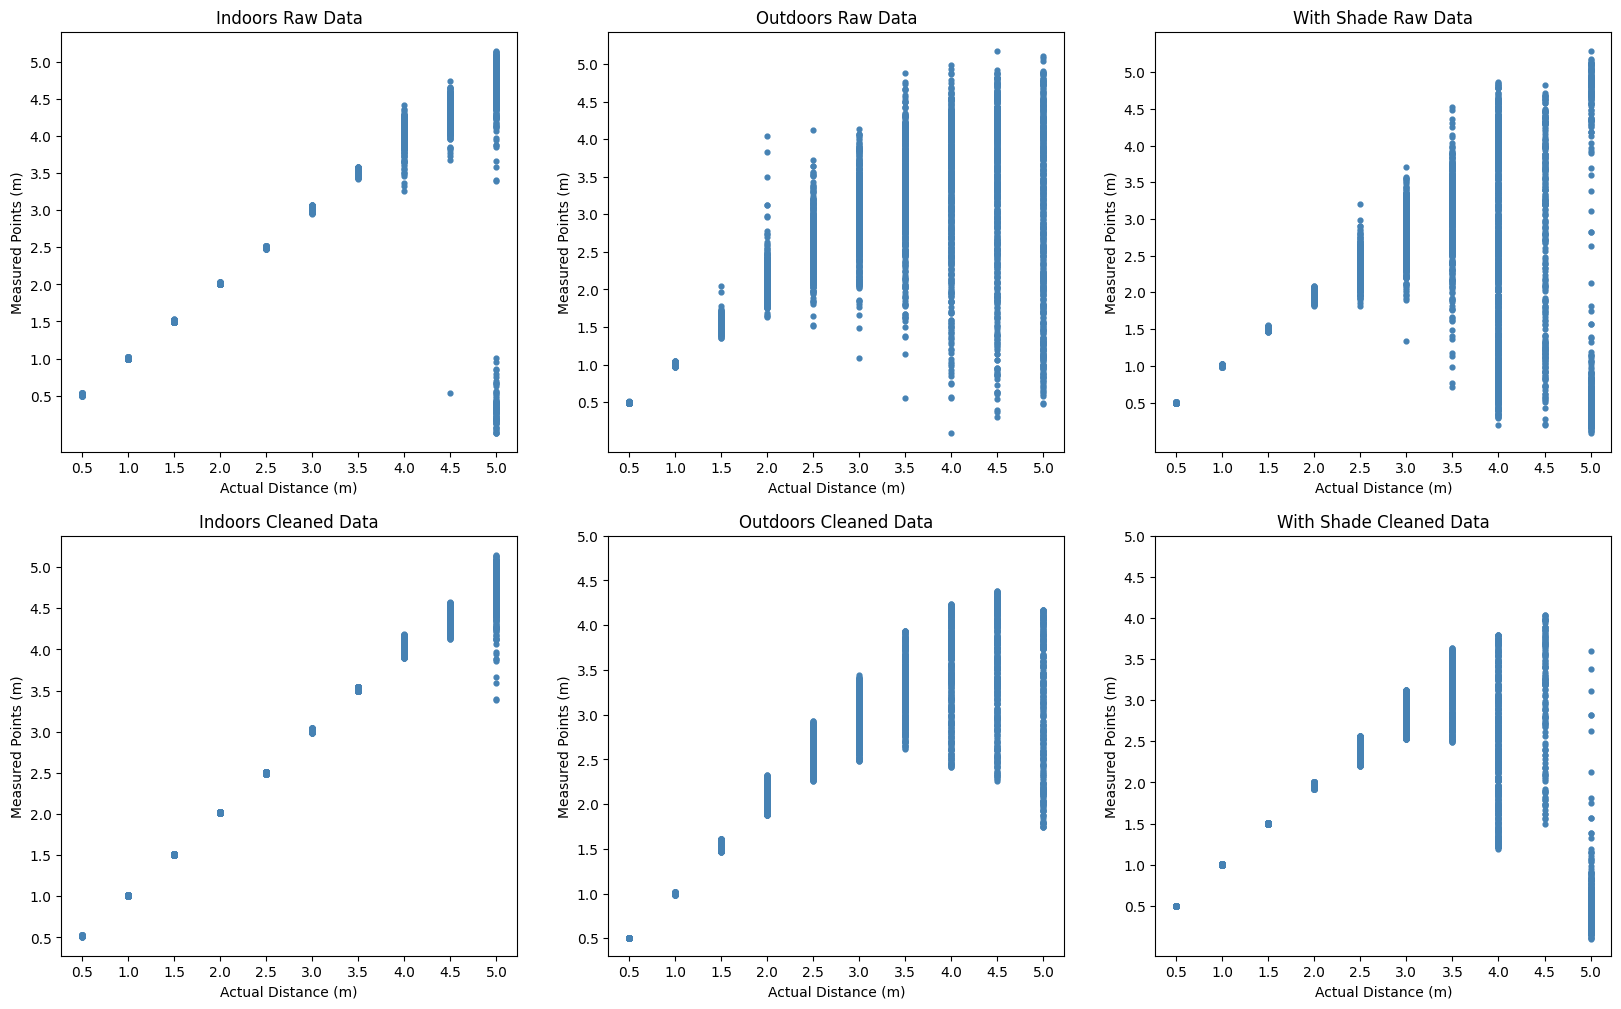

In [8]:
outdoors_cleaned = data_cleaner.clean_basic_test_data(outdoors_raw_data)
indoors_cleaned = data_cleaner.clean_basic_test_data(indoors_raw_data)
with_shade_cleaned = data_cleaner.clean_basic_test_data(with_shade_raw_data)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

graphs.plot_scatter(axes[0][0], indoors_raw_data, title="Indoors Raw Data")
graphs.plot_scatter(axes[0][1], outdoors_raw_data, title="Outdoors Raw Data")
graphs.plot_scatter(axes[0][2], with_shade_raw_data, title="With Shade Raw Data")

graphs.plot_scatter(axes[1][0], indoors_cleaned, title="Indoors Cleaned Data")
graphs.plot_scatter(axes[1][1], outdoors_cleaned, title="Outdoors Cleaned Data")
graphs.plot_scatter(axes[1][2], with_shade_cleaned, title="With Shade Cleaned Data")

plt.show()

#### Comparing Best Fit Lines

- From the graphs below, we can see that cleaning the data has some minor improvements to the reliability of the sensor.
- For the outdoors data, the improvement was slight with a slope of $0.62x$ to $0.67x$.
- However, the improvement was a lot more significant for the indoors data with a slope from $0.88x$ to $0.96x$, where it became almost similar to the $y = x$ line.
- In contrast, for the data with the shade, cleaning the data reduced its reliability with a slope from $0.39x$ to $0.29x$. This is likely because of the large amount of spurious points at the higher distance intervals which allowed the data to average out more consistently. And once they were removed, the average was no longer as accurate.
- Therefore, my first priority should be in removing the errors caused by over exposure to natural light, and I could then focus on cleaning the data as a secondary method to enhance the reliability of the data collected.

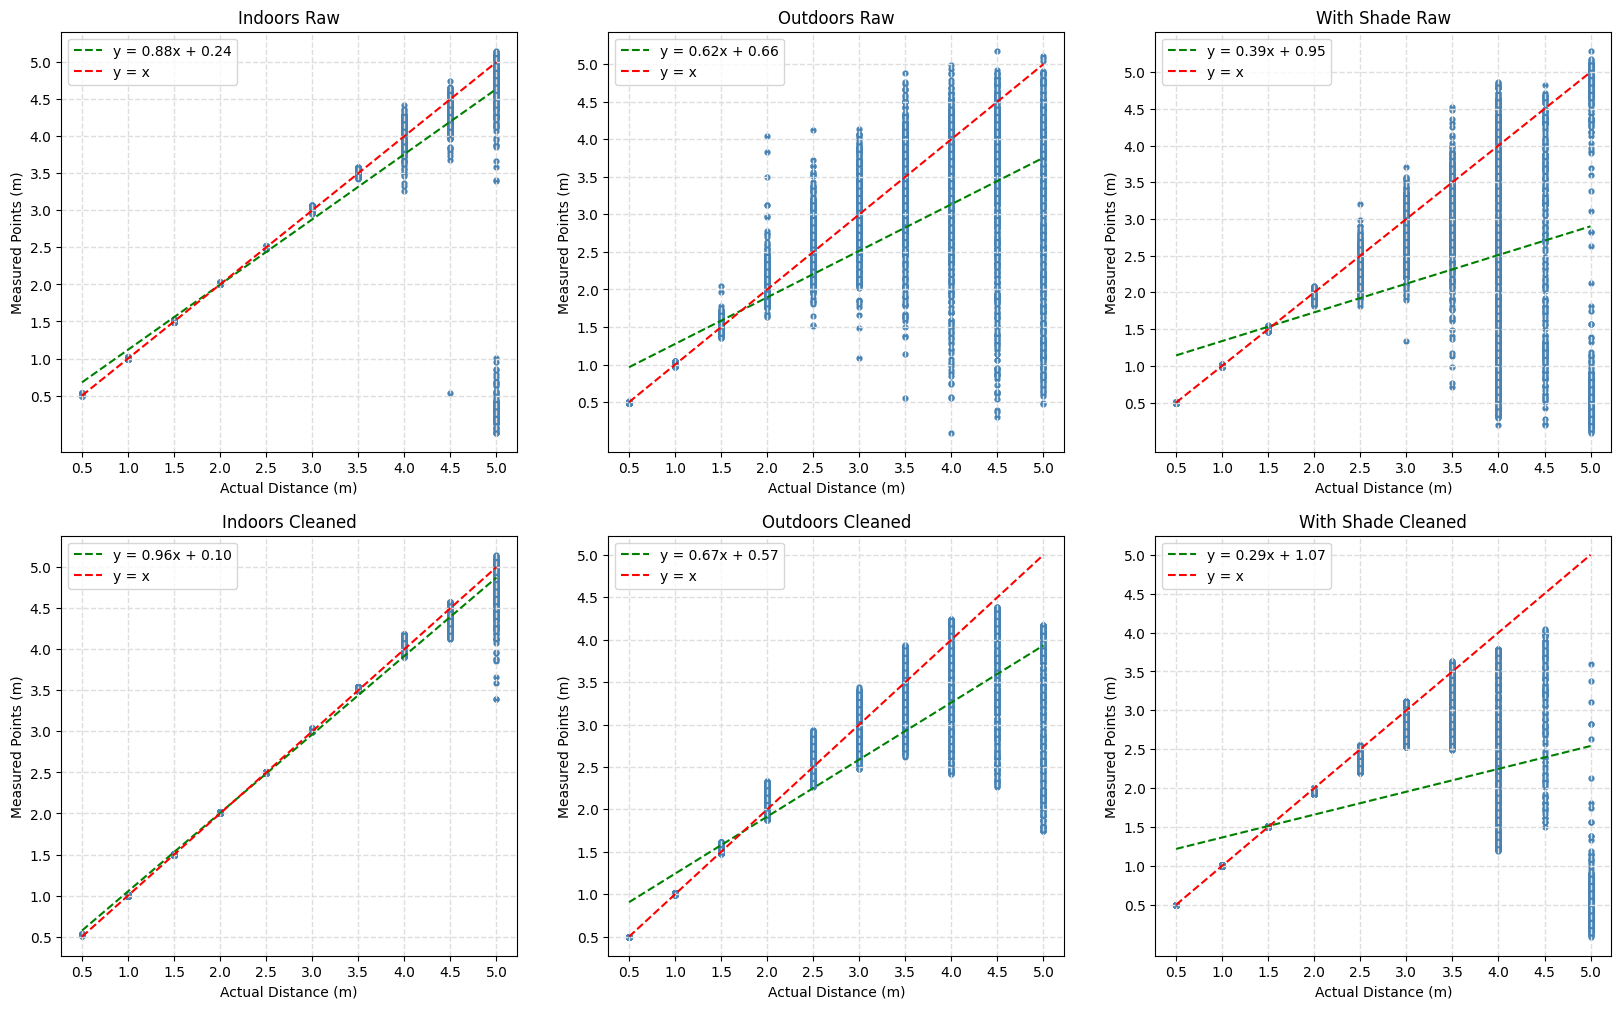

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

graphs.plot_best_fit_scatter(axes[0][0], indoors_raw_data, "Indoors Raw")
graphs.plot_best_fit_scatter(axes[0][1], outdoors_raw_data, "Outdoors Raw")
graphs.plot_best_fit_scatter(axes[0][2], with_shade_raw_data, "With Shade Raw")

graphs.plot_best_fit_scatter(axes[1][0], indoors_cleaned, title="Indoors Cleaned")
graphs.plot_best_fit_scatter(axes[1][1], outdoors_cleaned, title="Outdoors Cleaned")
graphs.plot_best_fit_scatter(axes[1][2], with_shade_cleaned, title="With Shade Cleaned")

plt.show()

## Conclusion

In conclusion, from these simple stationary tests, I was able to determine that the TOF sensor was in working condition and could measure distance. While it was very accurate in measuring distances up to 4m in an indoor environment, it performed poorly in an outdoor environment when exposed to natural light, and generated a lot of suprious data. To attempt to remedy this, I 3D-printed a case to act as a shield against the sunlight and tested it again. This was only effective at increasing the sensor's reliability at closer distances (i.e. 2m and less) and saw less spurious points being generated. However, at further distances, the casing impeded the sensor's measuring capabilities, as even a slight tilt in the angle could see the casing interfere with the sensor. Therefore, in practice I would use the sensor with the case. The aim of the project is to measure vehicles which closely overtake the cyclist (i.e. less than 2m), and for such distances the casing would be a good way to enhance the sensor's accuracy and precision.